In [1]:
import numpy as np
import pandas as pd
import scipy as scipy

import time

import matplotlib.pyplot as plt

In [2]:
from utils import gradient_descent, nesterov_descent, power_iteration

In [3]:
dim = 1000

B = np.random.randn(dim, dim)
eig_vals, U = np.linalg.eigh(B @ B.T)

eig_vals = np.logspace(-4, 4, dim, base=10)

A = U @ np.diag(eig_vals) @ U.T

In [4]:
timing_retries = 10

# Maximum Eigenvalue

In [5]:
scipy_time_taken = []
for i in range(timing_retries):
    start_time = time.time()
    max_eigval, _ = scipy.sparse.linalg.eigsh(A, k=1, which='LM', maxiter=10_000, tol=1e-8)
    end_time = time.time()
    
    scipy_time_taken.append(end_time - start_time)

max_eigval

array([10000.])

In [6]:
x = np.random.normal(0, 1, dim)

In [7]:
max_gd_time_taken = []

for i in range(timing_retries):
    start_time = time.time()
    out = gradient_descent(A, x.copy(), lr=100, which='max', maxiter=1000, tol=1e-10, save_history=True)
    end_time = time.time()
    
    max_gd_time_taken.append(end_time - start_time)

max_eigval, _, max_gd_history = out
max_eigval

np.float64(9999.999999997332)

In [8]:
max_power_time_taken = []

for i in range(timing_retries):
    start_time = time.time()
    out = power_iteration(A, x.copy(), maxiter=1000, tol=1e-10, save_history=True)
    end_time = time.time()
    
    max_power_time_taken.append(end_time - start_time)
    
max_eigval, _, max_power_history = out
max_eigval

np.float64(9999.999999997332)

In [9]:
max_nesterov_time_taken = []

for i in range(timing_retries):
    start_time = time.time()
    out = nesterov_descent(A, x.copy(), lr=100, which='max', maxiter=1000, tol=1e-10, save_history=True)
    end_time = time.time()
    
    max_nesterov_time_taken.append(end_time - start_time)
    
max_eigval, _, max_nesterov_history = out
max_eigval

np.float64(9999.999999999916)

# Minimum Eigenvalue

In [10]:
maxiter = 100_000

In [11]:
%%time
min_eigval, _ = scipy.sparse.linalg.eigsh(A, k=1, which='SM', maxiter=maxiter, tol=1e-8)
min_eigval

ArpackNoConvergence: ARPACK error -1: No convergence (100001 iterations, 0/1 eigenvectors converged)

In [12]:
x = np.random.normal(0, 1, dim)

In [13]:
min_gd_time_taken = []

for i in range(timing_retries):
    start_time = time.time()
    
    max_eigval, _ = gradient_descent(A, x.copy(), lr=100, which='max', maxiter=1000, tol=1e-10, 
                                     save_history=False)

    lr = 1 / (2.02 * max_eigval)
    out = gradient_descent(A, x.copy(), lr=lr, which='min', maxiter=maxiter, tol=1e-10, save_history=True)
    end_time = time.time()
    
    min_gd_time_taken.append(end_time - start_time)
    
min_eigval, _, min_gd_history = out

In [14]:
min_nesterov_time_taken = []

for i in range(timing_retries):
    start_time = time.time()
    max_eigval, _ = gradient_descent(A, x.copy(), lr=100, which='max', maxiter=1000, tol=1e-10, 
                                     save_history=False)

    lr = 1 / (2.02 * max_eigval)
    out = nesterov_descent(A, x.copy(), lr=lr, which='min', maxiter=maxiter, tol=1e-10, save_history=True)
    end_time = time.time()
    
    min_nesterov_time_taken.append(end_time - start_time)
    
min_eigval, _, min_nesterov_history = out
min_eigval

np.float64(0.00011269068867262756)

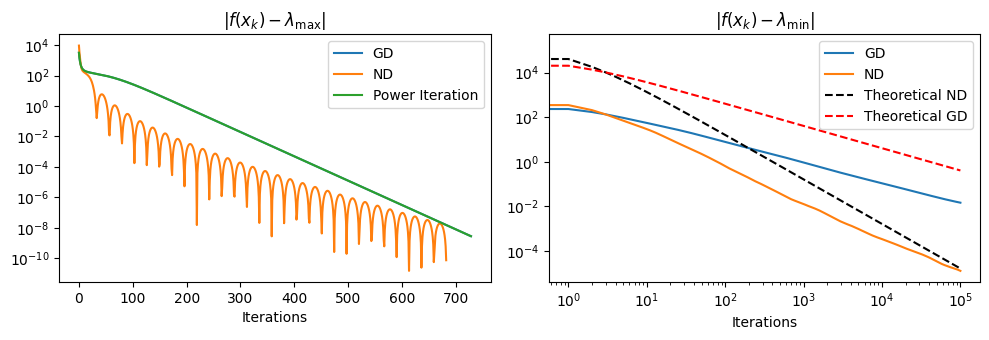

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

ax = axs[0]
ax.plot(abs(max_gd_history - max(eig_vals)), label='GD')
ax.plot(abs(max_nesterov_history - max(eig_vals)), label='ND')
ax.plot(abs(max_power_history - max(eig_vals)), label='Power Iteration')

ax.set_title('$|f(x_k) - \lambda_{\max}|$')
ax.set_xlabel('Iterations')

ax.set_yscale('log')
ax.legend()

k_vals = np.arange(1, len(min_nesterov_history))
ax = axs[1]
ax.plot(abs(min_gd_history - min(eig_vals)), label='GD')
ax.plot(abs(min_nesterov_history - min(eig_vals)), label='ND')
ax.plot(8 / (lr * k_vals ** 2), '--', color='black', label='Theoretical ND')
ax.plot(4 / (2 * lr * k_vals), '--', color='red', label='Theoretical GD')

ax.set_title('$|f(x_k) - \lambda_{\min}|$')
ax.set_xlabel('Iterations')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

plt.tight_layout()

plt.savefig('convergence.png', dpi=120);

In [24]:
max_time_taken

,GD,ND,Power
0,0.100820,0.091371,-35.561742
1,0.062617,0.071717,-35.649990
2,0.061156,0.068241,-35.711843
3,0.060921,0.071436,-35.773092
4,0.061152,0.091283,-35.833447


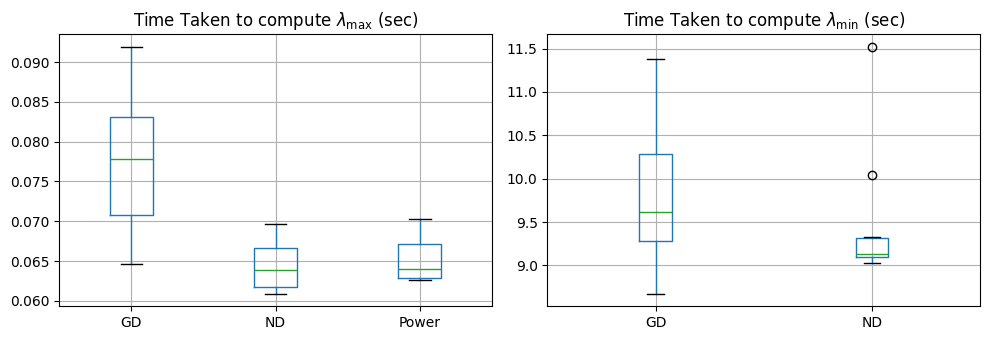

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

max_time_taken = pd.DataFrame([max_gd_time_taken, max_nesterov_time_taken, max_power_time_taken]).T
max_time_taken.columns = ['GD', 'ND', 'Power']

min_time_taken = pd.DataFrame([min_gd_time_taken, min_nesterov_time_taken]).T
min_time_taken.columns = ['GD', 'ND']

max_time_taken.boxplot(ax=axs[0])
min_time_taken.boxplot(ax=axs[1])

axs[0].set_title('Time Taken to compute $\lambda_{\max}$ (sec)')
axs[1].set_title('Time Taken to compute $\lambda_{\min}$ (sec)')

plt.tight_layout()

plt.savefig('time_taken.png', dpi=120);